<a href="https://colab.research.google.com/github/HSE-LAMBDA/MLatFIAN2021/blob/main/seminar05/MLatFIAN2021_seminar05_homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cross-validation riddle

Here's a small example of cross-validation done wrongly. Can you spot the problem?

In [18]:
# Some imports...
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score

**Plan:**

- Let's create a binary classification dataset where targets are completely independent from the features
  - *(i.e. no model could ever predict them well)*
- We'll do some simple feature selection
- And cross-validate a model on this data

**Q:** what accuracy do we expect (classes are even)?

We'll start from writing a class to select the best features:

In [45]:
class FeatureSelector:
  def __init__(self, num_features):
    self.n = num_features # number of best features to select

  def fit(self, X, y):
    # Select features that describe the targets best, i.e. have
    # highest correlation with them:
    covariance = ((X - X.mean(axis=0)) * (y[:,np.newaxis] - y.mean())).mean(axis=0)
    self.best_feature_ids = np.argsort(np.abs(covariance))[-self.n:]
    
  def fit_with_print(self, X, y):
    # Select features that describe the targets best, i.e. have
    # highest correlation with them:
    covariance = ((X - X.mean(axis=0)) * (y[:,np.newaxis] - y.mean())).mean(axis=0)
    print("Ковариация с метками тех признаков, что мы отобрали:\n",np.sort(np.abs(covariance))[-self.n:])
    print("--------\n")
    print("--------\n")
    print("Ковариация с метками признаков c ''cредней'' ковариацией:\n",np.sort(np.abs(covariance))[len(X)//2-self.n//2:len(X)//2+self.n//2])
    self.best_feature_ids = np.argsort(np.abs(covariance))[-self.n:]
    
  def new_fit(self, X, y):
    # Отбор без привязки к ковариации
    self.best_feature_ids = np.random.randint(0,len(X),self.n)

  def transform(self, X):
    return X[:,self.best_feature_ids]

  def fit_transform(self, X, y):
    self.fit(X, y)
    return self.transform(X)

  def new_fit_transform(self, X, y):
    self.new_fit(X, y)
    return self.transform(X)

  def fit_transform_with_print(self, X, y):
    self.fit_with_print(X, y)
    return self.transform(X)

In [46]:
num_features_total = 1000
num_features_best = 100

N = 100

# Dataset generation
X = np.random.normal(size=(N, num_features_total))
y = np.random.randint(2, size=N)

# Feature selection:
X_best = FeatureSelector(num_features_best).fit_transform(X, y)

# Simple classification model
model = LinearSVC()

# Estimatin accuracy using cross-validation:
cv_score = cross_val_score(model, X_best, y, scoring='accuracy', cv=10, n_jobs=-1).mean()
print(f"CV score is {cv_score}")

CV score is 0.8800000000000001


What's going on?! Why accuracy is so high?

Maybe it just happened by chance? Let's repeat this experiment many times and histogram the results:

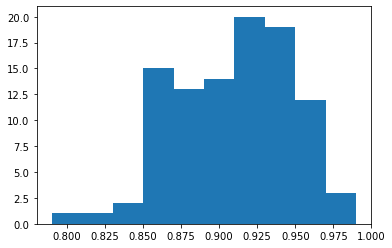

In [47]:
num_features_total = 1000
num_features_best = 100

N = 100
def experiment():
  # Dataset generation
  X = np.random.normal(size=(N, num_features_total))
  y = np.random.randint(2, size=N)

  # Feature selection:
  X_best = FeatureSelector(num_features_best).fit_transform(X, y)

  # Simple classification model
  model = LinearSVC()

  # Estimatin accuracy using cross-validation:
  return cross_val_score(model, X_best, y, scoring='accuracy', cv=10, n_jobs=-1).mean()

results = [experiment() for _ in range(100)]
plt.hist(results, bins=10);

Explain why the estimated model accuracy is not 50% on a dataset where targets were generated **independently from the features (!!!)**.

Find and fix the problem (don't change the dataset generation or its parameters - `num_features_total`, `num_features_best`, `N`).

*Hint: the problem is in the overall logic, and not a bug in the code.*

# Выполнение

Рассуждение: действительно, непонятно, как могла получиться столь высокая accuracy, ведь пространство признаков и метки фомируются неазвисимо (и случайно). Получается, следует ожидать accuracy около 50%.

Однако, как было сказано в подсказке, проблема заключается в логике. Скорее всего, дело в том, как мы отбираем признаки. Для нас критерием является ковариация, то есть оценка зависимости признаков и меток. И в целом неудивительно, что из 1000 признаков можно найти 100, которые при вот таком случайном заполнении оказались немного скореллированы с метками. Для интереса посмотрим на ковариацию тех признаков, которые были отобраны, и на ковариацию признаков со средней зависимостью (из середины упорядоченного списка ковариаций)

In [48]:
num_features_total = 1000
num_features_best = 100

N = 100

# Dataset generation
X = np.random.normal(size=(N, num_features_total))
y = np.random.randint(2, size=N)

# Feature selection:
X_best = FeatureSelector(num_features_best).fit_transform_with_print(X, y)

# Simple classification model
model = LinearSVC()

# Estimatin accuracy using cross-validation:
cv_score = cross_val_score(model, X_best, y, scoring='accuracy', cv=10, n_jobs=-1).mean()
print(f"CV score is {cv_score}")

Ковариация с метками тех признаков, что мы отобрали:
 [0.07953982 0.07981498 0.08011564 0.08016717 0.08040591 0.08053774
 0.0806384  0.08073732 0.08147338 0.08147645 0.08207456 0.08243326
 0.0825204  0.08258564 0.08261434 0.08326462 0.08339943 0.08379402
 0.08380933 0.08449025 0.08451653 0.08516265 0.08551663 0.0858474
 0.08590962 0.08617799 0.08663049 0.08702971 0.08743339 0.08768469
 0.08780606 0.08793364 0.08824192 0.08884687 0.08914908 0.08948246
 0.09042    0.09091412 0.09096844 0.09103113 0.09182305 0.09186592
 0.09212464 0.09300912 0.09376759 0.09404427 0.09410175 0.09410243
 0.09455569 0.0946746  0.09474571 0.0948946  0.09552803 0.09561282
 0.09604832 0.09711032 0.09772415 0.09772552 0.09799159 0.09850038
 0.09990679 0.10025051 0.10153029 0.1024509  0.10245508 0.10553747
 0.10576943 0.10633635 0.10635324 0.10659407 0.10693029 0.10798752
 0.10813292 0.10917162 0.10978382 0.10989864 0.11015646 0.11033933
 0.11103158 0.11455102 0.11548685 0.11595783 0.11611362 0.11678057
 0.117202

Таким образом, мы видим, что у отобранных признаков ковариация достигает 0.2, что на 2-3-4 порядка больше "средней" ковариации. Таким образом, мы поступаем нечестно, потому что мы вручную отобрали те признаки, которые линейно зависимы с метками и по ним строим нашу разделяющую плоскость. Чтобы проверить, что именно в этом причина столь выскокой accuracy, произведём все те же проверки, но при отборе признаков откажемся от привязки к ковариации (new_fit).

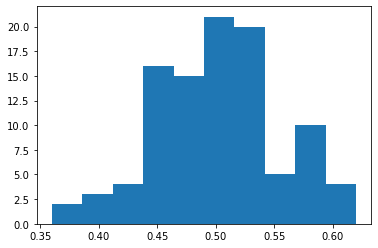

In [49]:
num_features_total = 1000
num_features_best = 100

N = 100
def experiment():
  # Dataset generation
  X = np.random.normal(size=(N, num_features_total))
  y = np.random.randint(2, size=N)

  # Feature selection:
  X_best = FeatureSelector(num_features_best).new_fit_transform(X, y)

  # Simple classification model
  model = LinearSVC()

  # Estimatin accuracy using cross-validation:
  return cross_val_score(model, X_best, y, scoring='accuracy', cv=10, n_jobs=-1).mean()

results = [experiment() for _ in range(100)]
plt.hist(results, bins=10);

Получили то, что и ожидали! Максимум на 50%.